In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn.linear_model import BayesianRidge
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import ExtraTreeClassifier
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from itertools import cycle
import lightgbm
import catboost
import xgboost
#import shap
from scipy import interp
#import seaborn as sns
from catboost import *
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score
#%matplotlib
###########wrapping root mean square error for later calls##########
def compute_mae_mse_rmse(target,prediction):
    error = []
    for i in range(len(target)):
        error.append(target[i] - prediction[i])
    squaredError = []
    absError = []
    for val in error:
        squaredError.append(val * val)  # target-prediction之差平方
        absError.append(abs(val))  # 误差绝对值
    mae=sum(absError)/len(absError)  # 平均绝对误差MAE
    mse=sum(squaredError)/len(squaredError)  # 均方误差MSE
    RMSE=np.sqrt(sum(squaredError)/len(squaredError))
    R2=r2_score(target,prediction)
    return mae,mse,RMSE,R2
###########loading data##########
fdata=pd.read_csv('database_filled_CD.csv',encoding="gbk")
raw_data=fdata.loc[:,[
                      'Operating Temperature (℃)',#0
                      'Flow Rate (mL min-1)',#1    
                      'Active Area (cm2)', #2
                      'Ir wt. %',#3
                      'Ru wt.%',#4
                      'O wt. %',#5
                      'I/C in Anode',#6
                      'Pt wt. %',#7
                      'I/C in Cathode',#8  
                      'Anode Precious Metal Loading (mg cm-2 Ir/Ru/Pt/Pd)',#9
                      'Cathode Precious Metal Loading (mg cm-2 Pt/Pd)',#10
                      'Membrane Thickness (μm)',#11
                      'EW'#12
                        ]]
###########train test splitting##########
raw_param=raw_data.iloc[:,0:13]
print('ready')

ready


In [9]:
CD15=fdata.loc[:,['Current at 1.5 V']]

In [3]:
def summarize(list1):
    total=0
    for ele in range(0, len(list1)):
        total = total + list1[ele]
    return total

In [4]:
def gridsearch(model,param,algorithm_name):
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-1)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction_07=result
    y_real_07=y_test[:,0]
    x_prediction_07_series=pd.Series(x_prediction_07)
    y_real_07_series=pd.Series(y_real_07)
    
    result_train = best_model.predict(X_train)
    x_prediction_07_train=result_train
    y_real_07_train=y_train[:,0]
    x_prediction_07_series_train=pd.Series(x_prediction_07_train)
    y_real_07_series_train=pd.Series(y_real_07_train)
    
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_07_series.corr(y_real_07_series), 5)
    error_val= compute_mae_mse_rmse(x_prediction_07,y_real_07)
    
    corr_ann_train = round(x_prediction_07_series_train.corr(y_real_07_series_train), 5)
    error_val_train= compute_mae_mse_rmse(x_prediction_07_train,y_real_07_train)
    
    print(algorithm_name)
    print(best_model.feature_importances_)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    print(error_val,'TEST R2',error_val[3],'TEST CORR',corr_ann)
    print(error_val_train,'TRAIN R2',error_val_train[3],'TRAIN CORR',corr_ann_train)
    x_y_x=np.arange(0,0.8,0.1)
    x_y_y=np.arange(0,0.8,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction_07,y_real_07,color='red',label=algorithm_name+' Test Set',alpha=0.75)
    ax.scatter(x_prediction_07_train,y_real_07_train,color='blue',label=algorithm_name+' Training Set',alpha=0.25,marker="^")
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"Predicted_Current_Density (mA cm^-2)@1.5V (vs. RHE)")
    plt.ylabel(u"Real_Current_Density (mA cm^-2)@1.5V (vs. RHE)")
    plt.savefig('CD15 SEL %s.png' %algorithm_name)
    print('finished')

In [10]:
seed=530
X_train, X_test, y_train, y_test = train_test_split(raw_param, CD15, test_size=.15,random_state=seed)

In [11]:
train=pd.concat([X_train,y_train],axis=1)
train.to_csv('REG15_train.csv')
test=pd.concat([X_test,y_test],axis=1)
test.to_csv('REG15_test.csv')

In [6]:
from catboost import *
import shap
def shap_plot(model,param,algorithm_name):
    print(algorithm_name)
    SHAP_INPUT=raw_data.iloc[:,0:13]
    SHAP_OUTPUT=CD15
    grid = GridSearchCV(model,param_grid=param,cv=5,n_jobs=-100)
    grid.fit(X_train,y_train)
    best_model=grid.best_estimator_
    X_SHAP=SHAP_INPUT.values.astype(np.float32)
    y_SHAP=SHAP_OUTPUT
    if algorithm_name=='CatBoost':
        shap_values = best_model.get_feature_importance(Pool(X_SHAP,y_SHAP), type="ShapValues")
        shap_values=shap_values[:,:-1]
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    elif algorithm_name=='Random Forest' or algorithm_name=='Extra Tree'or algorithm_name=='Decision Tree'or algorithm_name=='AdaBoost':
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)
    else:
        explainer = shap.TreeExplainer(best_model,X_SHAP)
        shap_values = explainer.shap_values(X_SHAP,check_additivity= False)
        shap.summary_plot(shap_values, SHAP_INPUT,max_display=100)
        global_importances = np.abs(shap_values).mean(0)
        print(global_importances)

In [7]:
##########LGBM gridsearch CV for best hyperparameter##########
model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
param_light = {
'boosting_type':['gbdt','rf'],
'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
'n_estimators':[50,100,200,400],
'max_depth':[5,7,9,11,13,-1],
'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
}
gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
'n_estimators':[100,200,400],
'max_depth':[5,7,9,11,13],
'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
'reg_alpha':[0,0.001,0.01,0.0001,0.00001],
'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
}
gridsearch(model_XGBRegressor,param_xg,'XGBoost')

##########CatBoost gridsearch CV for best hyperparameter##########
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {
'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
'n_estimators':[50,100,200,400],
'max_depth':[5,7,9,11],
'boosting_type':['Plain'],
'subsample':[0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1],
'reg_lambda':[0,0.001,0.01,0.0001,0.00001]
}
gridsearch(model_CatRegressor,param_cat,'CatBoost')


###########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
'n_estimators':[50,100,200,400],
'max_depth':[3,5,7,9,11,13,16],
'criterion':['friedman_mse','mae','mse'],
'max_features':['auto','sqrt','log2'],
'loss':['ls', 'lad', 'huber', 'quantile']
}
gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[50,100,200,400,None],
'max_depth':[3,5,7,9,11,None],
'criterion':['mse','mae'],
'max_features':['auto','sqrt','log2']
}
gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')


###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
param_ET = {
'max_depth':[5,6,7,8,9,10,11,None],
'max_features':['auto','sqrt','log2'],
'criterion' : ["mse", "friedman_mse", "mae"],
'splitter' : [ "best",'random']
}
gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')


###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
param_DT = {
'max_depth':[5,6,7,8,9,10,11,None],
'max_features':['auto','sqrt','log2'],
'criterion' : ["mse", "friedman_mse", "mae"],
'splitter' : [ "best",'random']
}
gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')


###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
param_Ada = {
'n_estimators':[50,100,200,400,800],
'learning_rate':[0.001,0.002,0.004,0.005,0.006,0.008,0.01,0.02,0.04,0.06,0.05,0.06,0.08,0.1,0.12,0.14,0.15,0.16,0.18,0.2,0.4,0.5,0.6,0.8,1],
'loss':['linear', 'square', 'exponential']
}
gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

Converting column-vector to 1d array


LightGBM
[118 107  49  27  10  38 149  72 146 129  64  51  34]
Best Regressor: {'boosting_type': 'gbdt', 'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.4} Best Score: 0.6735732681144191
(0.0568236178030559, 0.0060566476001618205, 0.07782446659092383, 0.8095234346955332) TEST R2 0.8095234346955332 TEST CORR 0.90898
(0.028151673656270252, 0.0025343922117010984, 0.050342747359486635, 0.8982911251411774) TRAIN R2 0.8982911251411774 TRAIN CORR 0.95597
finished


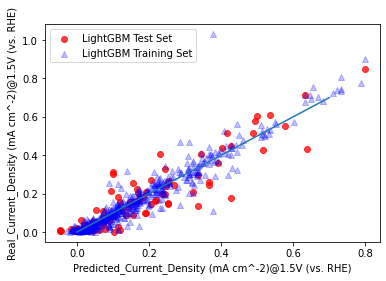

In [8]:
##########LGBM gridsearch CV for best hyperparameter##########
model_LightGBMRegressor=lightgbm.LGBMRegressor(random_state=1,verbose=-1)
param_light = {
'boosting_type':['gbdt'],
'learning_rate':[0.4],
'subsample':[0.4],
'n_estimators':[100],
'max_depth':[5],
'reg_alpha':[0.01],
'reg_lambda':[0.01]
}
gridsearch(model_LightGBMRegressor,param_light,'LightGBM')

In [10]:
%matplotlib
shap_plot(model_LightGBMRegressor,param_light,'LightGBM')

Using matplotlib backend: Qt5Agg
LightGBM


Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array
Converting column-vector to 1d array


[0.07999034 0.02164299 0.02794855 0.00894065 0.00441978 0.00974967
 0.02383331 0.01619837 0.02519082 0.02447157 0.01735683 0.01634779
 0.00650693]


XGBoost
[0.12706576 0.06367244 0.1303017  0.04122014 0.12645756 0.02872355
 0.06376451 0.04773623 0.06690369 0.04030706 0.08462389 0.12990765
 0.04931577]
Best Regressor: {'booster': 'gbtree', 'learning_rate': 0.06, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0.001, 'subsample': 0.7} Best Score: 0.6438861912439812
(0.04783175996564932, 0.004930946946345218, 0.07022070169362606, 0.8350733591905675) TEST R2 0.8350733591905675 TEST CORR 0.92516
(0.014143281905803348, 0.0013356724968599627, 0.03654685344677381, 0.9498909718847255) TRAIN R2 0.9498909718847255 TRAIN CORR 0.977
finished


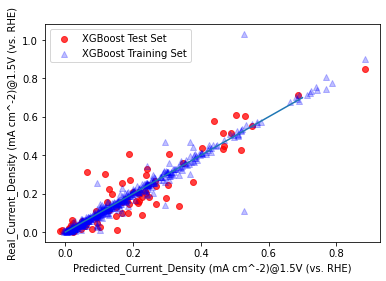

In [9]:
##########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor=xgboost.XGBRegressor(objective='reg:squarederror',random_state=1,verbosity=0)
param_xg = {
'booster':['gbtree'],
'learning_rate':[0.06],
'n_estimators':[200],
'max_depth':[7],
'subsample':[0.7],
'reg_alpha':[0.01],
'reg_lambda':[0.001]
}
gridsearch(model_XGBRegressor,param_xg,'XGBoost')

In [13]:
shap_plot(model_XGBRegressor,param_xg,'XGBoost')

XGBoost
[0.08369742 0.01602403 0.01990013 0.00521407 0.01102199 0.00416089
 0.01760462 0.00855875 0.01501608 0.0159323  0.01137143 0.01723736
 0.00886161]


In [ ]:
##########CatBoost gridsearch CV for best hyperparameter##########
model_CatRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {
'max_depth':[13],
'boosting_type':['Plain'],
'subsample':[0.8],
'reg_lambda':[0.01]
}
gridsearch(model_CatRegressor,param_cat,'CatBoost')

In [15]:
shap_plot(model_CatRegressor,param_cat,'CatBoost')

CatBoost
[0.05199108 0.01050074 0.01006994 0.00668928 0.0084907  0.00807045
 0.01136121 0.01105825 0.0128162  0.01058321 0.01056326 0.01872996
 0.00630881]


In [16]:
 ##########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=1)
###########defining the parameters dictionary##########
param_GB = {
'learning_rate':[0.08],
'n_estimators':[50],
'max_depth':[11],
'criterion':['mae'],
'max_features':['sqrt'],
'loss':['huber']
}
gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoost
[0.22802104 0.10255325 0.06593768 0.03252118 0.03224059 0.04749527
 0.10247144 0.0635784  0.08171448 0.08663027 0.07249913 0.05217638
 0.0321609 ]
Best Regressor: {'criterion': 'mae', 'learning_rate': 0.08, 'loss': 'huber', 'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 50} Best Score: 0.689522985040927
(0.04987601703462211, 0.005247668819525709, 0.0724407952712124, 0.8063792852322929) TEST R2 0.8063792852322929 TEST CORR 0.92034
(0.012011953106390177, 0.0021804954790596237, 0.04669577581601599, 0.9119328454488282) TRAIN R2 0.9119328454488282 TRAIN CORR 0.963
finished


In [17]:
shap_plot(model_GradientBoostingRegressor,param_GB,'GradientBoost')

GradientBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.05712607 0.0155059  0.01383243 0.00614924 0.00729227 0.00701989
 0.01130393 0.01034471 0.0111443  0.01059736 0.00747541 0.01483987
 0.00331736]


In [18]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=1)
###########defining the parameters dictionary##########
param_RF = {
'n_estimators':[200],
'max_depth':[None],
'criterion':['mae'],
'max_features':['sqrt']
}
gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Random Forest
[0.22625518 0.09041928 0.06729833 0.03753464 0.02516346 0.04304391
 0.10788814 0.06212255 0.09223117 0.0948989  0.07196636 0.04773773
 0.03344034]
Best Regressor: {'criterion': 'mae', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200} Best Score: 0.6508820315052345
(0.05215391725862074, 0.005602472495464317, 0.07484966596762017, 0.7739024738321147) TEST R2 0.7739024738321147 TEST CORR 0.91641
(0.028288864715987773, 0.0024760913080392882, 0.049760338705029813, 0.8836936059830841) TRAIN R2 0.8836936059830841 TRAIN CORR 0.96257
finished


In [19]:
shap_plot(model_RandomForestRegressor,param_RF,'Random Forest')


Random Forest


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 94%|=================== | 542/578 [00:14<00:00]       

[0.05795581 0.01148642 0.0143737  0.00660917 0.00694842 0.00589219
 0.01082888 0.00944796 0.00961396 0.00862556 0.00714127 0.01231837
 0.00337669]


In [20]:
###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=1)
param_ET = {
'max_depth':[9],
'max_features':['auto'],
'criterion' : [ "mae"],
'splitter' : [ "best"]
}
gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.28745947 0.12461813 0.10027502 0.03021487 0.07027635 0.02392547
 0.06350652 0.0570712  0.04089749 0.07172998 0.06434731 0.06162504
 0.00405312]
Best Regressor: {'criterion': 'mae', 'max_depth': 9, 'max_features': 'auto', 'splitter': 'best'} Best Score: 0.5242974184763484
(0.0630041178735632, 0.008489481999165624, 0.09213838504752307, 0.7514144148749164) TEST R2 0.7514144148749164 TEST CORR 0.87777
(0.040186651710794295, 0.006664736641507299, 0.08163783829516372, 0.7090010482705638) TRAIN R2 0.7090010482705638 TRAIN CORR 0.8787
finished


In [21]:
shap_plot(model_ExtraTreeRegressor,param_ET,'Extra Tree')

Extra Tree
[0.06145908 0.03021646 0.02028851 0.00570605 0.02216532 0.00409519
 0.00726643 0.01285942 0.01433399 0.01737849 0.00857852 0.02082485
 0.00070404]


In [22]:
###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=1)
param_DT = {
'max_depth':[9],
'max_features':['auto'],
'criterion' : [ "mae"],
'splitter' : [ "best"]
}
gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.28745947 0.12461813 0.10027502 0.03021487 0.07027635 0.02392547
 0.06350652 0.0570712  0.04089749 0.07172998 0.06434731 0.06162504
 0.00405312]
Best Regressor: {'criterion': 'mae', 'max_depth': 9, 'max_features': 'auto', 'splitter': 'best'} Best Score: 0.5242974184763484
(0.0630041178735632, 0.008489481999165624, 0.09213838504752307, 0.7514144148749164) TEST R2 0.7514144148749164 TEST CORR 0.87777
(0.040186651710794295, 0.006664736641507299, 0.08163783829516372, 0.7090010482705638) TRAIN R2 0.7090010482705638 TRAIN CORR 0.8787
finished


In [23]:
shap_plot(model_DecisionTreeRegressor,param_DT,'Decision Tree')

Decision Tree
[0.06145908 0.03021646 0.02028851 0.00570605 0.02216532 0.00409519
 0.00726643 0.01285942 0.01433399 0.01737849 0.00857852 0.02082485
 0.00070404]


In [24]:
###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=1)
param_Ada = {
'n_estimators':[200],
'learning_rate':[0.06],
'loss':['exponential']
}
gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AdaBoost
[0.40213752 0.01523325 0.07702059 0.01504623 0.01358219 0.01138621
 0.05716029 0.04263484 0.03235333 0.01993338 0.14988761 0.09025504
 0.07336952]
Best Regressor: {'learning_rate': 0.06, 'loss': 'exponential', 'n_estimators': 200} Best Score: 0.3711992756236916
(0.09443819841250198, 0.015863323832324982, 0.12594968770237178, -0.5819031410431963) TEST R2 -0.5819031410431963 TEST CORR 0.76698
(0.09335111590540578, 0.014249541852245168, 0.11937144487793204, -0.45725002051360497) TRAIN R2 -0.45725002051360497 TRAIN CORR 0.74331
finished


In [25]:
shap_plot(model_AdaBoostRegressor,param_Ada,'AdaBoost')

AdaBoost


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[0.0625658  0.00197961 0.00896299 0.00186602 0.00197809 0.00209607
 0.00922961 0.00682206 0.00380592 0.00468244 0.02190441 0.01788368
 0.00688368]
